# DE analysis and EDA

In this thread, we discuss DE analysis and EDA to identify potential issues. 

## Summary:
Overall, new approach can do the followings differently and see how the results improve:
- Not filling the missing values and reporting DE values for only those genes with measured counts
- Using a different type of pseudobulking, e.g. taking mean instead of summing.
- Using a different model for DE fitting, e.g. non linear.
- Taking into account the number of cells for each pseudobulked sample. We can see certain samples have only one cell.
- idea of working with t-scores instead of signlog10p
- seperate analysis for cell type vs combined
- cell type as a factor
- 

## Plan
Jalil ->work on different DE analysis. Choice of normalizing, limma or not limma, etc. If someone has experience with DE analysis, would be appreciated to help me.
 
@lnalinaf @antoninadolgorukova -> can you start with EDA and define some kind of protocol to identify potential issues? the orignal  de-train can be a default input while i produce new results. we can continue on how to define this protocol in the comments. 

## Notebooks and data

Notebook to load kaggle_data and pseudobulk it:
https://www.kaggle.com/code/jalilnourisa/op2-post-pseudobulking?scriptVersionId=163713576 

Notebook that analyzes the issues with the original de-train data  
https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/discussion/466181


## Experiment setup
https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/data
- 6 plates, 2 plates for each of 3 donors 
- 144 compounds + 3 controls
- per plate: 96 wells, 72 compounds (one well each) + 3 (8 well each) control 
- all different cell types are assumed to be in each well 

**Potential confounders**: donor, row (wells of each row are put together for sequencing), and plate.

## Pseudobulking 
**Method used by the hosts for DE analysis:**: 
Single cell measurements are aggregated for cell types of each well (of each plate). 
**Potential alternative approach:**: 
We can take mean of counts instead of summing. 

## Method choice
**Method used by the hosts for DE analysis:**: 
- they used Voom function that normalizes the pseudobulked data and also fills the missing values for genes with 0 counts. It should be noted that we have around 40% missingness after pseudobulking. **Issues**: we get DE values for 0 count genes.
- Model design: for each cell type and gene:
$$
x_0 + x_1c_i + x_2l_i + x_3d_i + x_4p_i
$$
i is for observations, where:
- $c_i$ compound, binary (0, 1) for control and given treatment (double check?) (or 146 categorical) 
- $l_i$ library, categorical 48 conditions
- $d_i$ donor, categorical 3 conditions
- $p_i$ plate, categorical 6 conditions 
  
  **Issues**

- library_id already includes plate and donor -> maybe using row (8 conditions) can help in stability of the solution 

**Potential alternative approach:**: 
- no filling the missing genes. 
- using a different fitting model


Antonina Dolgorukova
Alina F

# Imports 

In [4]:
import scipy

import os, binascii
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import anndata as ad
# import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

data_dir = '../../input/kaggle/input/open-problems-single-cell-perturbations'
bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row']
cell_types = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
train_cell_types =  ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']

outliers_me = ['AT13387', 'Alvocidib', 'BMS-387032', 'CEP-18770 (Delanzomib)',
       'CGM-097', 'CGP 60474', 'Ganetespib (STA-9090)', 'I-BET151',
       'IN1451', 'LY2090314', 'MLN 2238', 'Oprozomib (ONX 0912)',
       'Proscillaridin A;Proscillaridin-A', 'Resminostat',
       'UNII-BXU45ZH6LI', 'Vorinostat']

control_compound = 'Dimethyl Sulfoxide'
os.path.isdir(data_dir)

from matplotlib.patches import Patch
# the stacked bar code is adopted from Ambrosm
def plot_stacked_bar_chart(cell_types_in_drops, title, xticks=None, xticklabels=None, colors=None, figsize=(25, 4)):
    """Plot a stacked bar chart of cell counts
    
    The plot has one vertical bar per drop, and every cell type gets
    its own color.

    We dont show the controls as they are too tall.
    
    Parameters:
    cell_types_in_drops: array of shape (n_drops, n_cell_types)
    xticks, xticklabels: parameters for plt.xticks, shape (n_drops,)
    """
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)

    plt.figure(figsize=figsize)
    for i in range(len(cell_types)):
        plt.bar(np.arange(len(cc_cs)),
                cc_cs[:,i+1] - cc_cs[:,i],
                bottom=cc_cs[:,i],
                label=cell_types[i])
    plt.legend()
    plt.title(title)
    first_legend = plt.legend(title='Cell Types')
    if xticks is not None:
        plt.xticks(xticks, xticklabels, rotation=90)
    
    ax = plt.gca()
    for ticklabel, color in zip(ax.get_xticklabels(), colors):
        ticklabel.set_color(color)

    color_legend_handles = [
        Patch(facecolor='red', label='-'),
        Patch(facecolor='blue', label='-'),
        Patch(facecolor='green', label='-'),
    ]
    # color_legend = ax.legend(handles=color_legend_handles, title='X-tick Label Colors', loc='upper right', bbox_to_anchor=(1, 1))
    ax.add_artist(first_legend)
    plt.show()

# Format adata

In [15]:
adata_train_df = pd.read_parquet(os.path.join(data_dir, 'adata_train.parquet'))
adata_obs_meta_df = pd.read_csv(os.path.join(data_dir, 'adata_obs_meta.csv'))
de_train = pd.read_parquet(os.path.join(data_dir, 'de_train.parquet'))
adata_excluded_ids_df = pd.read_csv(os.path.join(data_dir, 'adata_excluded_ids.csv'))

: 

In [ ]:
reindexed_adata_train_df = adata_train_df.reset_index().set_index(['obs_id', 'gene'])
adata_excluded_ids_index = adata_excluded_ids_df.set_index(['obs_id', 'gene']).sort_index().index

selection = ~reindexed_adata_train_df.index.isin(adata_excluded_ids_index)
adata_train_df = reindexed_adata_train_df[selection]

adata_train_df = adata_train_df.reset_index().set_index('index')

In [ ]:
adata_train_df['obs_id'] = adata_train_df['obs_id'].astype('category')
adata_train_df['gene'] = adata_train_df['gene'].astype('category')

obs_ids = adata_train_df['obs_id'].unique()
obs_id_map = dict(zip(obs_ids, range(len(obs_ids))))

genes = adata_train_df['gene'].unique()
gene_map = dict(zip(genes, range(len(genes))))

adata_train_df['obs_index'] = adata_train_df['obs_id'].map(obs_id_map)
adata_train_df['gene_index'] = adata_train_df['gene'].map(gene_map)

normalized_counts_values = adata_train_df['normalized_count'].to_numpy()
counts_values = adata_train_df['count'].to_numpy()

row_indices = adata_train_df['obs_index'].to_numpy()
col_indices = adata_train_df['gene_index'].to_numpy()

counts = scipy.sparse.csr_matrix((counts_values, (row_indices, col_indices)))

obs_df = pd.Series(obs_ids, name='obs_id').to_frame()
var_df = pd.Series(genes, name='gene').to_frame()

obs_df = obs_df.set_index('obs_id')
var_df = var_df.set_index('gene')

obs_df.index = obs_df.index.astype('str')
var_df.index = var_df.index.astype('str')

kaggle_adata = ad.AnnData(
    X=counts,
    obs=obs_df,
    var=var_df,
    dtype=np.uint32,
)

index_ordering_before_join = kaggle_adata.obs.index
kaggle_adata.obs = kaggle_adata.obs.join(adata_obs_meta_df.set_index('obs_id'))
index_ordering_after_join = kaggle_adata.obs.index
assert (index_ordering_before_join == index_ordering_after_join).all()

kaggle_adata.write_h5ad('../../output/de_analysis/kaggle_adata.h5ad')

# Pseudobulking counts by cell type

In [ ]:
import anndata
import pandas as pd
import numpy as np
import sklearn
import scipy
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message="The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated")
warnings.filterwarnings('ignore', category=UserWarning, message="No data for colormapping provided via 'c'")

import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt

import os, binascii
kaggle_adata = anndata.read_h5ad('../../output/de_analysis/kaggle_adata.h5ad')

In [ ]:
kaggle_adata

AnnData object with n_obs × n_vars = 240090 × 18211
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control'

In [ ]:
from scipy import sparse

def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [ ]:
# aggregate single cell measurements for each well (of each plate)
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_name'].astype('str') \
    + '_' + kaggle_adata.obs['well'].astype('str') \
    + '_' + kaggle_adata.obs['cell_type'].astype('str')
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_well_cell_type'].astype('category')
# actuall bulking
bulk_adata = sum_by(kaggle_adata, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = kaggle_adata.obs.groupby('plate_well_cell_type').size().values
bulk_adata.obs = bulk_adata.obs.drop(columns=['plate_well_cell_type'])
bulk_adata.X = np.array(bulk_adata.X.todense())
plate_name_update = {
    'plate_0': 'plate_2',
     'plate_1': 'plate_3',
     'plate_2': 'plate_1',
     'plate_3': 'plate_4',
     'plate_4': 'plate_0',
     'plate_5': 'plate_5',
}

bulk_adata.obs['plate_name'] = bulk_adata \
    .obs['plate_name'] \
    .map(plate_name_update) \
    .astype('str')

print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)
bulk_adata.var = bulk_adata.var.reset_index()

ratio of missingness 0.4181703709564913


In [ ]:

bulk_adata.write_h5ad('../../output/de_analysis/bulk_adata.h5ad')

bulk_adata_df = pd.DataFrame(bulk_adata.X, columns=bulk_adata.var.index, index=bulk_adata.obs.index)
bulk_adata_df = pd.concat([bulk_adata.obs[bulk_index],  bulk_adata_df], axis=1).set_index(bulk_index)
bulk_adata_df.to_csv('../../output/de_analysis/bulk_adata_df.csv')


# EDA 

In [3]:
bulk_adata = ad.read_h5ad('../../output/de_analysis/bulk_adata.h5ad')
bulk_adata_df = pd.read_csv('../../output/de_analysis/bulk_adata_df.csv').set_index(bulk_index)

In [17]:
aa = (bulk_adata.X != 0).sum(axis=0)
aa.sort()
aa

array([   5,   16,   16, ..., 2558, 2558, 2558])

## Stats

In [ ]:
sample_n = bulk_adata.obs.groupby(['cell_type', 'sm_name']).size().unstack('cell_type')
sample_n.loc[:, train_cell_types] = sample_n.loc[:, train_cell_types].fillna(0) # fill nans and sort for train cell type

sample_n['total'] = sample_n[train_cell_types].sum(axis=1) # Sort by the four training cell types
sample_n.sort_values('total', inplace=True)
sample_n.tail()

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells,total
sm_name,,,,,,,
GW843682X,0,0,3,3,3,3,12
HMN-214,0,0,3,3,3,3,12
Belinostat,48,48,48,48,12,21,129
Dimethyl Sulfoxide,48,48,48,48,48,48,192
Dabrafenib,48,48,48,48,48,48,192


144


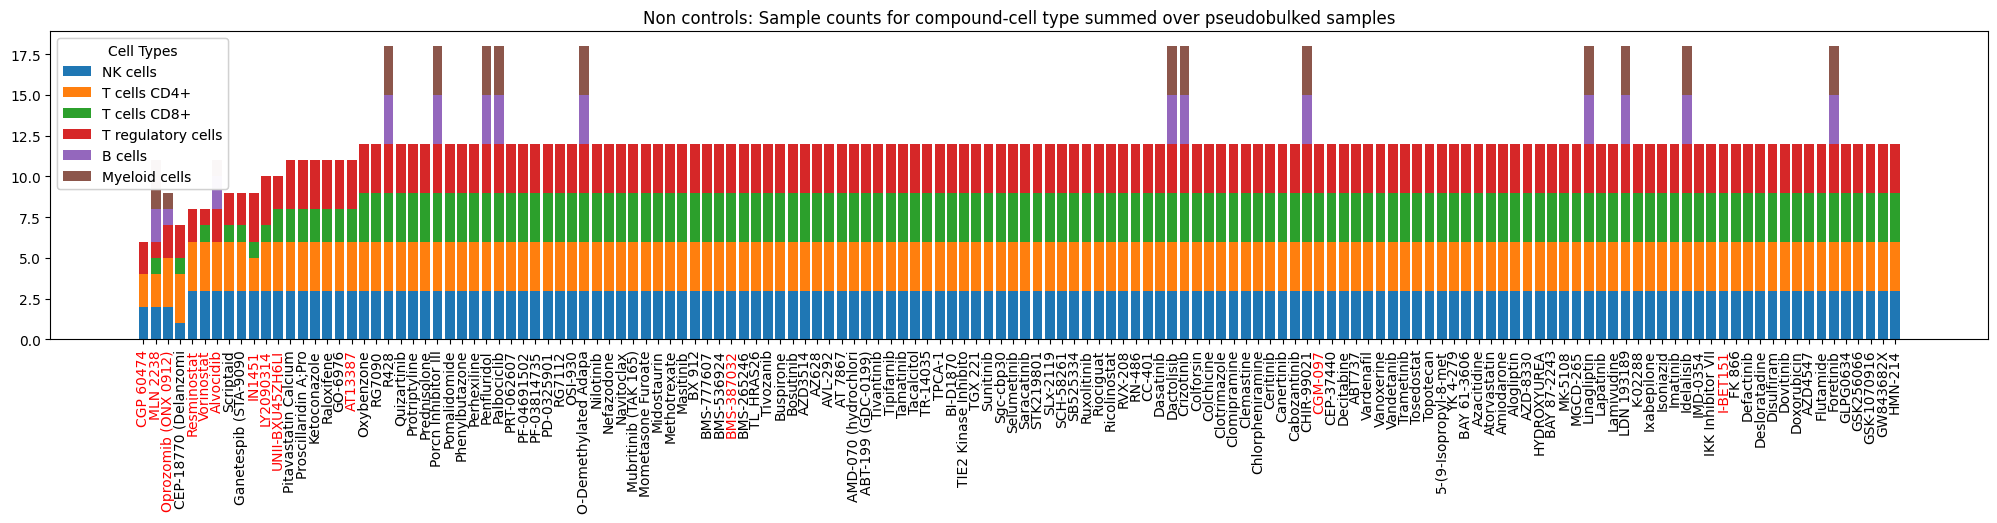

In [ ]:
# Plot for non controls
cc = sample_n.loc[~sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    if sm_name in outliers_me:
        colors.append('red')
    else:
        colors.append('black')

plot_stacked_bar_chart(cc[cell_types].values, 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(25, 4))

3


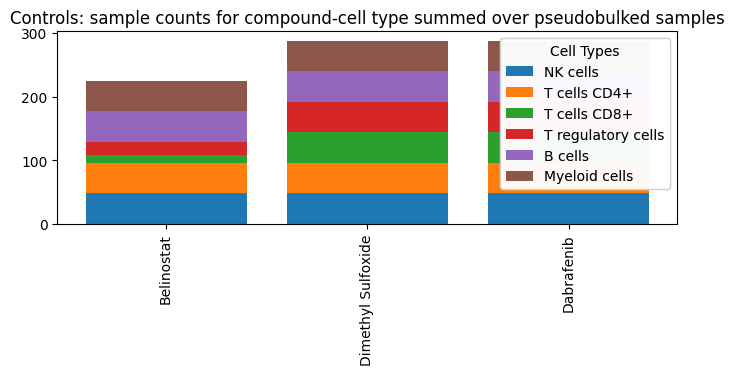

In [ ]:
# Plot for non controls
cc = sample_n.loc[sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    colors.append('black')

plot_stacked_bar_chart(cc[cell_types].values, 'Controls: sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(8, 2.5))

In [1]:
import os
# Optional: set the device to run
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import joblib
from sklearn.datasets import make_regression
import numpy as np

# simple case - just one class is used
from py_boost import GradientBoosting
from py_boost.cv import CrossValidation

X, y = make_regression(150000, 100, n_targets=10, random_state=42)
X_test, y_test = X[:50000], y[:50000]
X, y = X[-50000:], y[-50000:]

model = GradientBoosting('mse', 'r2',
                         ntrees=1000, lr=.01, verbose=100, es=200, lambda_l2=1,
                         subsample=.8, colsample=.8, min_data_in_leaf=10, min_gain_to_split=0, 
                         max_bin=256, max_depth=6)

model.fit(X, y, eval_sets=[{'X': X_test, 'y': y_test},])

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/py_boost/__init__.py:38: UserWarning: No Nvidia GPU detected! Only treelite inference on CPU is available
  warnings.warn('No Nvidia GPU detected! Only treelite inference on CPU is available')


ImportError: cannot import name 'GradientBoosting' from 'py_boost' (/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/py_boost/__init__.py)

## Missing counts issues 

### Pseudobulk data

In [1]:
bulk_adata

NameError: name 'bulk_adata' is not defined

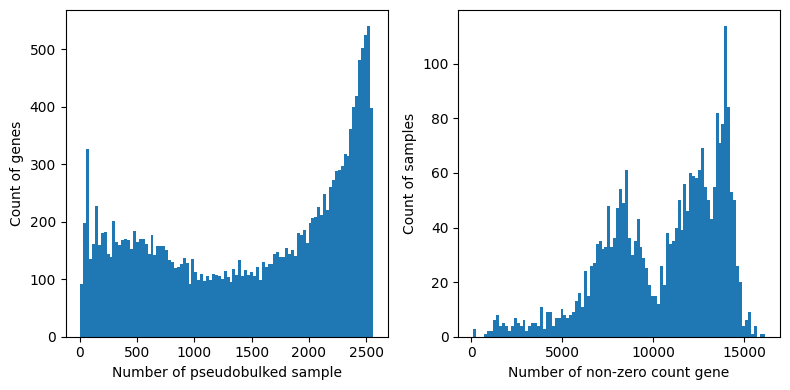

In [ ]:
mask_nonzero =  bulk_adata.X!=0
fig, axes = plt.subplots(1,2, figsize=(8,4))
ax = axes[0]
ax.hist(mask_nonzero.sum(axis=0), bins=100)
ax.set_xlabel('Number of pseudobulked sample')
ax.set_ylabel('Count of genes')
# ax.set_title('Distribution of non-zero count gene ')

ax = axes[1]
ax.hist(mask_nonzero.sum(axis=1), bins=100)
ax.set_xlabel('Number of non-zero count gene')
ax.set_ylabel('Count of samples')
# ax.set_title('Number of genes for samples')
plt.tight_layout()

### Compound-cell type grouped

ratio of missing  0.3001338633252587


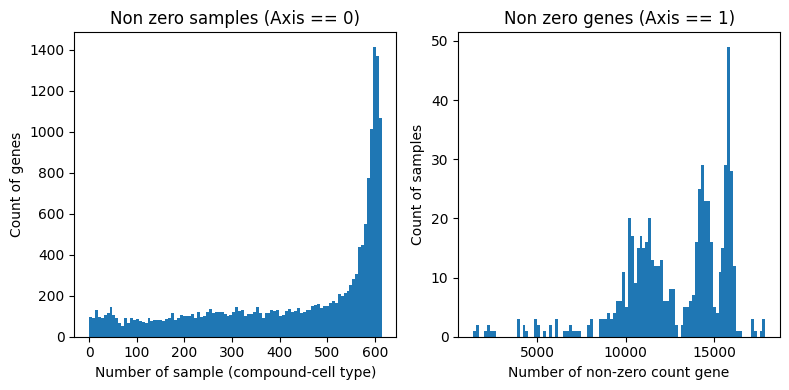

In [ ]:
# get the number of non zero samples for sm_name cell type pairs
samples_n_df = bulk_adata_df.groupby(level=['sm_name', 'cell_type']).apply(lambda df: (df!=0).sum(axis=0)).dropna()
# masks
mask_nonzero = samples_n_df!=0
mask_nonzero_ctr = mask_nonzero[mask_nonzero.index.get_level_values('sm_name')==control_compound]
# multiply mask of compounds to control -> those left
def multiply_ctr(df):
    df_dropped = df.reset_index(level='sm_name', drop=True)
    df_ctr = mask_nonzero_ctr.reset_index(level='sm_name', drop=True) # multiply with ctr samples
    return df_dropped.mul(df_ctr).dropna(axis=0) # drop nan
mask_nonzero_ctr_mul = mask_nonzero.groupby(level='sm_name').apply(lambda df: multiply_ctr(df))
# remove control
mask_nonzero = mask_nonzero_ctr_mul[mask_nonzero_ctr_mul.index.get_level_values('sm_name')!=control_compound]
print('ratio of missing ' , (mask_nonzero==0).sum().sum()/mask_nonzero.size)
# save
mask_nonzero.to_csv('../../output/postprocess/EDA/mask_nonzero.csv')
# plot
fig, axes = plt.subplots(1,2, figsize=(8,4))
ax = axes[0]
ax.hist(mask_nonzero.sum(axis=0), bins=100)
ax.set_xlabel('Number of sample (compound-cell type)')
ax.set_ylabel('Count of genes')
ax.set_title('Non zero samples (Axis == 0)')

ax = axes[1]
ax.hist(mask_nonzero.sum(axis=1), bins=100)
ax.set_xlabel('Number of non-zero count gene')
ax.set_ylabel('Count of samples')
ax.set_title('Non zero genes (Axis == 1)')
plt.tight_layout()

## Low cell count issue

In [ ]:
bulk_adata.obs['cell_count'].min()

1

In [ ]:
cell_count = bulk_adata.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].sum())

In [ ]:
cell_count_m = cell_count.unstack('cell_type') # shape (n_compounds, n_cell_types) matrix
cell_count_m.loc[:, train_cell_types] = cell_count_m.loc[:, train_cell_types].fillna(0) # fill nans and sort for train cell type

cell_count_m['total'] = cell_count_m[train_cell_types].sum(axis=1) # Sort by the number of cells of the four training cell types
cell_count_m.sort_values('total', inplace=True)


144


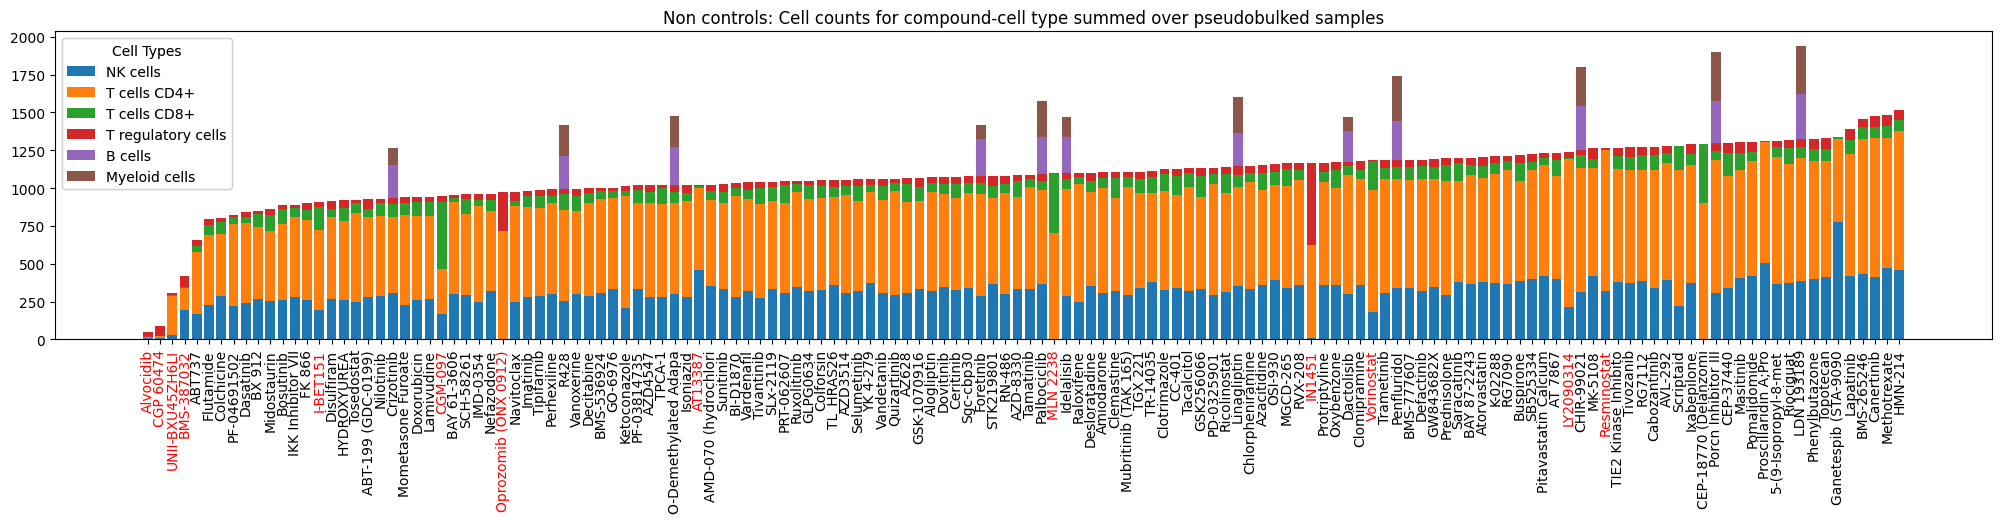

In [ ]:
# Plot for non controls
cc = cell_count_m.loc[~cell_count_m.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    if sm_name in outliers_me:
        colors.append('red')
    else:
        colors.append('black')

plot_stacked_bar_chart(cc[cell_types].values, 'Non controls: Cell counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors)

3


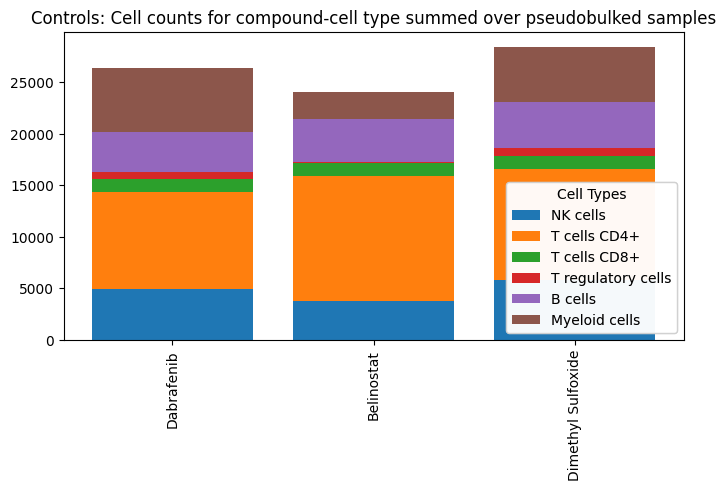

In [ ]:
# Plot for  controls
cc = cell_count_m.loc[cell_count_m.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    colors.append('black')

plot_stacked_bar_chart(cc[cell_types].values, 'Controls: Cell counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(8, 4))

## Filtering

### Filtering with edgeR

In [ ]:
%%R -o filtered_data_edgR
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)
adata_de = readH5AD('../../output/de_analysis/bulk_adata.h5ad')

filter_func <- function(adata_){
    d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name, genes=rowData(adata_)$gene)
    print("Dimensions before subsetting:")
    print(dim(d))
    keep <- filterByExpr(d)
    d <- d[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(d))
    d <- calcNormFactors(d)
    return (d)
}
filtered_data_edgR <-filter_func(adata_de)

/root/.cache/R/basilisk/1.14.3/zellkonverter/1.12.1/zellkonverterAnnDataEnv-0.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[1] "Dimensions before subsetting:"
[1] 18211  2558
[1] "Dimensions after subsetting:"
[1] 12097  2558


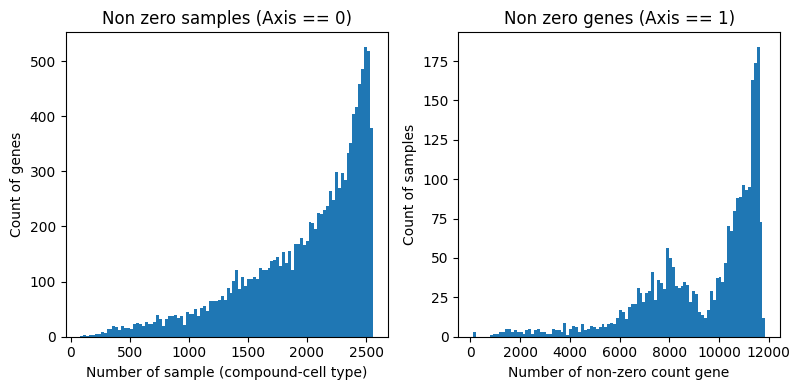

In [ ]:
filtered_df_edger = pd.DataFrame(filtered_data_edgR['counts'].T, columns=filtered_data_edgR['genes'].genes.values)
mask_nonzero = filtered_df_edger != 0
fig, axes = plt.subplots(1,2, figsize=(8,4))
ax = axes[0]
ax.hist(mask_nonzero.sum(axis=0), bins=100)
ax.set_xlabel('Number of sample (compound-cell type)')
ax.set_ylabel('Count of genes')
ax.set_title('Non zero samples (Axis == 0)')

ax = axes[1]
ax.hist(mask_nonzero.sum(axis=1), bins=100)
ax.set_xlabel('Number of non-zero count gene')
ax.set_ylabel('Count of samples')
ax.set_title('Non zero genes (Axis == 1)')
plt.tight_layout()

### Outlier compounds

In [ ]:
mask_row_compounds = ~bulk_adata.obs.sm_name.isin(outliers_me)

### All together

In [ ]:
# genes suggested by figr
genes_by_edger = filtered_df_edger.columns
# extra filtering on genes 
min_sample = 500
mask_min_sample = (bulk_adata.X!=0).sum(axis=0)>=min_sample
genes_by_minsample = bulk_adata.var[mask_min_sample].gene.values
# combine
genes_to_retain = np.intersect1d(genes_by_minsample, genes_by_edger)

mask_cols = bulk_adata.var['gene'].isin(genes_to_retain)
genes_to_retain.shape

(11930,)

In [ ]:
bulk_adata_f = bulk_adata[mask_row_compounds, mask_cols]
bulk_adata_f.shape

(2402, 11930)

### EDA after filtering

In [ ]:
sample_n = bulk_adata_f.obs.groupby(['cell_type', 'sm_name']).size().unstack('cell_type')
sample_n.loc[:, train_cell_types] = sample_n.loc[:, train_cell_types].fillna(0) # fill nans and sort for train cell type

sample_n['total'] = sample_n[train_cell_types].sum(axis=1) # Sort by the four training cell types
sample_n.sort_values('total', inplace=True)
sample_n.tail()

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells,total
sm_name,,,,,,,
Colchicine,0,0,3,3,3,3,12
Clotrimazole,0,0,3,3,3,3,12
Belinostat,48,48,48,48,12,21,129
Dimethyl Sulfoxide,48,48,48,48,48,48,192
Dabrafenib,48,48,48,48,48,48,192


128


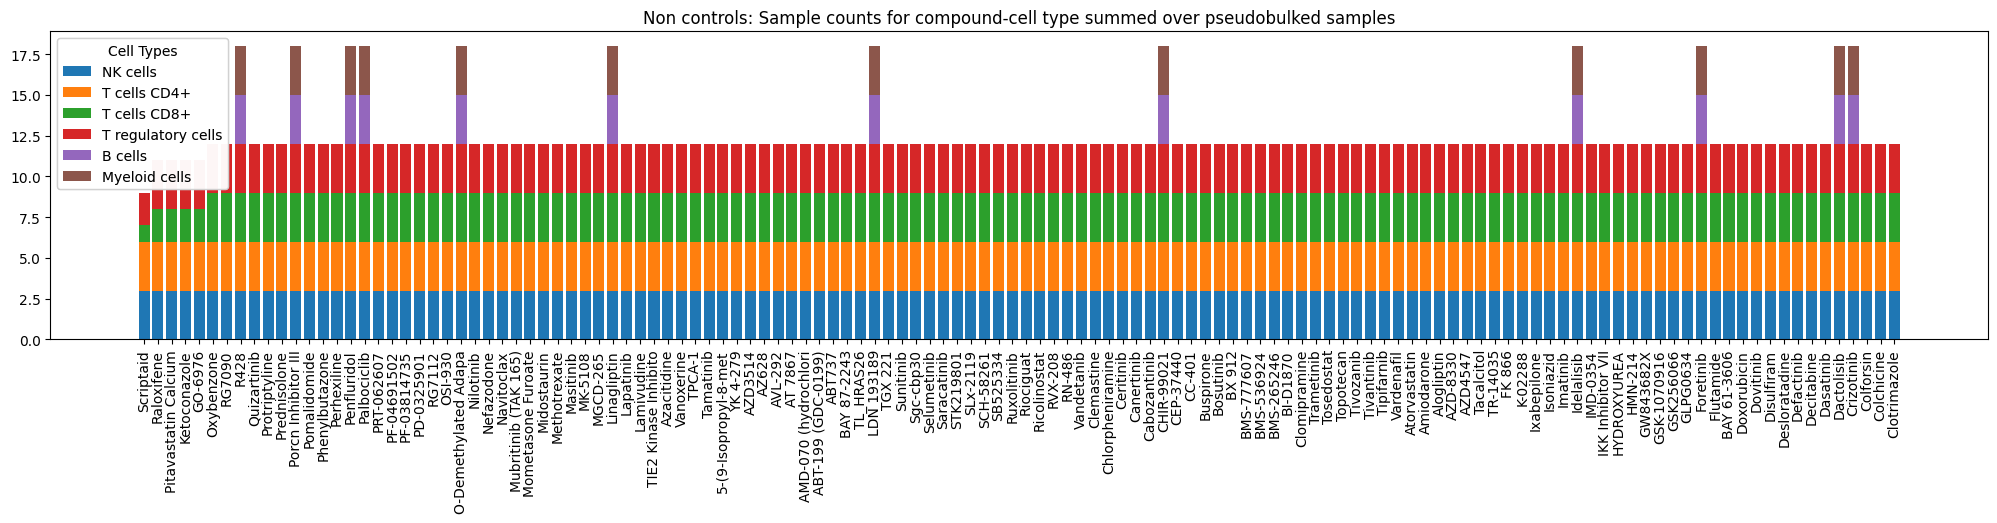

In [ ]:
# Plot for non controls
cc = sample_n.loc[~sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    if sm_name in outliers_me:
        colors.append('red')
    else:
        colors.append('black')

plot_stacked_bar_chart(cc[cell_types].values, 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(25, 4))

In [ ]:
# save filtered adata
bulk_adata_f.write_h5ad('../../output/de_analysis/bulk_adata_f.h5ad')

## UMAP and PCA 

In [ ]:
adata_eda = bulk_adata_f.copy()
adata_eda.layers['counts'] = adata_eda.X
# pca 
sc.pp.normalize_total(adata_eda, target_sum=1e6)
sc.pp.log1p(adata_eda)
sc.pp.pca(adata_eda, n_comps=100)
# umap 
sc.pp.neighbors(adata_eda, n_neighbors=20, n_pcs=100)
sc.tl.umap(adata_eda)

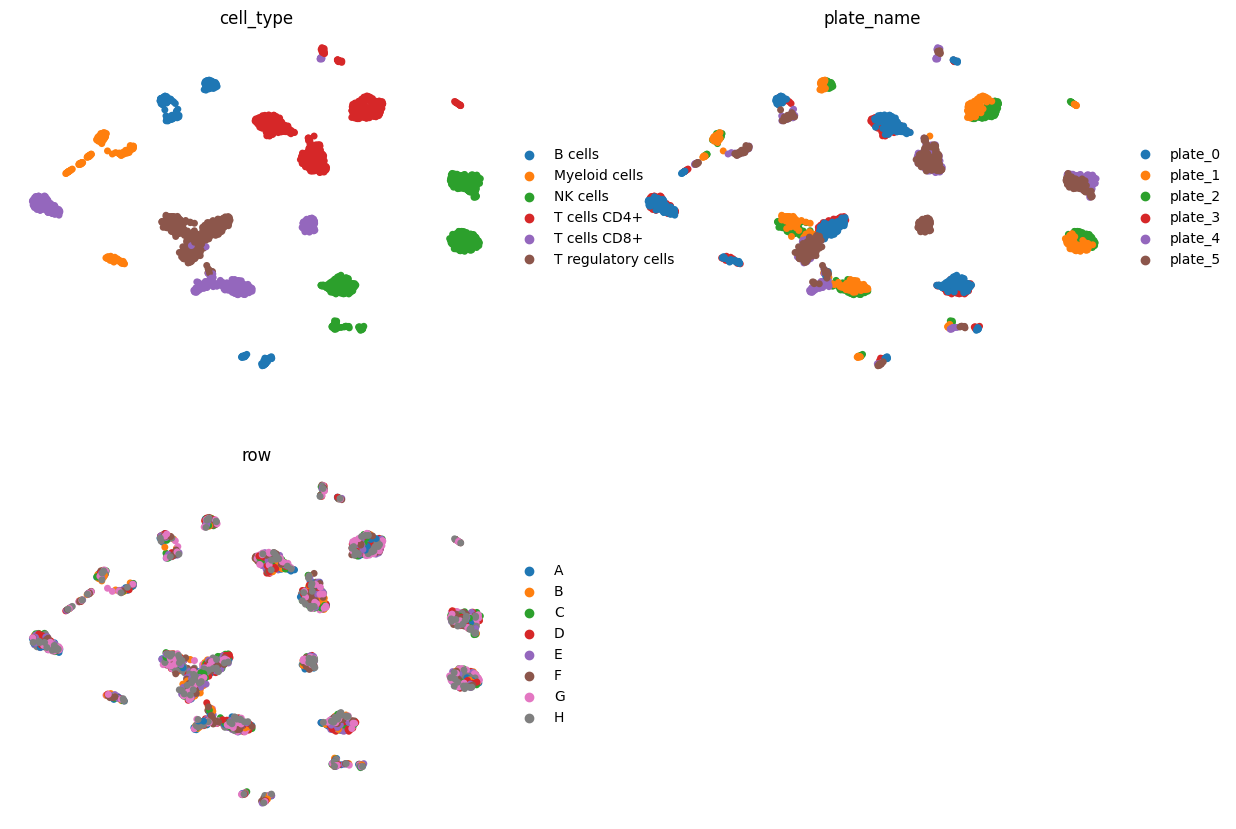

In [ ]:
sc.pl.umap(adata_eda, color=['cell_type', 'plate_name', 'row'], frameon=False, ncols=2, size=100)

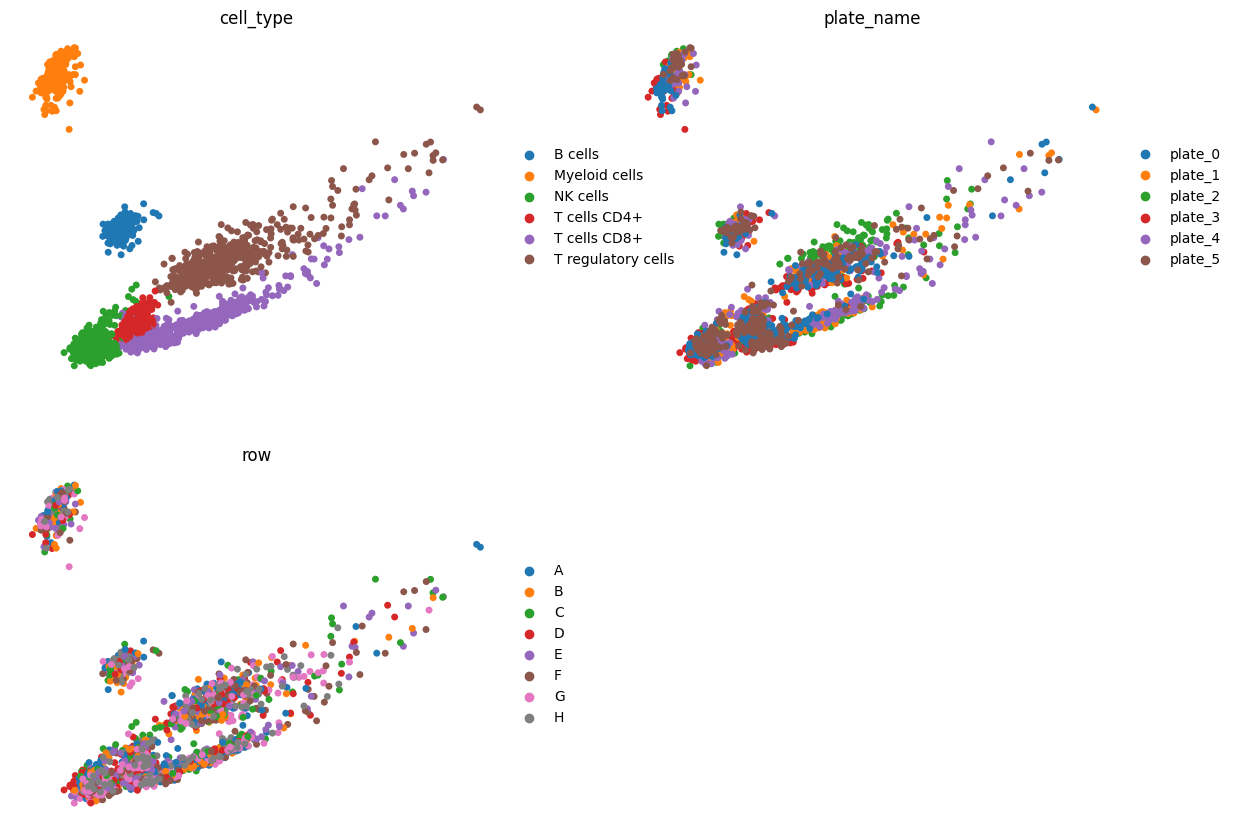

In [ ]:
sc.pl.pca(adata_eda, color=['cell_type', 'plate_name', 'row'], frameon=False, ncols=2, size=100)

## Normalize

### Scanpy

In [ ]:
bulk_adata_f_n = bulk_adata_f.copy()
bulk_adata_f_n.layers['counts'] = bulk_adata_f_n.X

In [ ]:
bulk_adata_f_n.X = bulk_adata_f_n.layers['counts']
sc.pp.normalize_total(bulk_adata_f_n, target_sum=10**6)
sc.pp.log1p(bulk_adata_f_n)

In [ ]:
import scanpy.external as sce
sce.pp.magic(bulk_adata_f_n, knn=20, n_pca=20, solver='exact')

  Running MAGIC with `solver='exact'` on 11930-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


In [ ]:
bulk_adata_f_n.write_h5ad('../../output/de_analysis/bulk_adata_f_n.h5ad')


In [ ]:
aaaaa

NameError: name 'aaaaa' is not defined

### EdgeR 

In [ ]:
%%time
%%R -o normalized_data
library(edgeR)
library(zellkonverter)
options(max.print=100)
library(SingleCellExperiment)
bulk_adata = readH5AD('../../output/de_analysis/bulk_adata_f.h5ad')



normalize <- function(adata_) {
    d <- DGEList(assay(adata_, "X"), 
                 group = colData(adata_)$sm_name, 
                 genes = rowData(adata_)$gene, 
                 samples = colData(adata_)$sm_name)
    print("Dimensions before subsetting:")
    print(dim(d))
    d <- calcNormFactors(d)
    group <- colData(adata_)$sm_name
    plate_name <- colData(adata_)$plate_name
    row <- colData(adata_)$row
    design <- model.matrix(~ 0 + group  + plate_name + row)
    print("Dimensions of design matrix:")
    print(dim(design))
    y <- estimateDisp(d, design = design)
    return(y)
}
# Identify unique cell types
cell_types <- unique(colData(bulk_adata)$cell_type)[0:1]
normalized_data <- list()
for (ctype in cell_types) {
    print(ctype)
    subset_sce <- bulk_adata[, colData(bulk_adata)$cell_type == ctype]
    normalized_subset <- normalize(subset_sce)
    normalized_data[[ctype]] <- normalized_subset
}

[1] "NK cells"
[1] "Dimensions before subsetting:"
[1] 11930   528
[1] "Dimensions of design matrix:"
[1] 528 143


# DE analysis 
We use https://www.sc-best-practices.org/conditions/differential_gene_expression.html.

In [5]:
bulk_adata = ad.read_h5ad('../../output/de_analysis/bulk_adata_f.h5ad')
adata_de = bulk_adata.copy()
adata_de

AnnData object with n_obs × n_vars = 2402 × 11930
    obs: 'SMILES', 'cell_id', 'col', 'library_id', 'plate_name', 'donor_id', 'dose_uM', 'timepoint_hr', 'row', 'control', 'sm_lincs_id', 'cell_type', 'sm_name', 'well', 'cell_count'
    var: 'gene'

In [6]:
adata_de.X

array([[ 9,  3,  6, ...,  0,  0,  0],
       [35,  7, 21, ...,  6,  0,  0],
       [ 3,  0,  0, ...,  0,  0,  0],
       ...,
       [47,  7, 27, ...,  0,  0,  0],
       [ 9,  0,  4, ...,  0,  0,  0],
       [ 8,  1,  4, ...,  0,  0,  1]], dtype=uint32)

### Format adata

In [7]:
control_compound = 'Dimethyl Sulfoxide'
compound_name_col = 'sm_name'

#  limma doesn't like dashes etc. in the names
# sm_name
unique_sm_name = adata_de.obs.sm_name.unique()
sm_name_map = {sm_name:f'sm_name_{number}' for sm_name, number in zip(unique_sm_name, range(len(unique_sm_name)))}
# cell type
unique_cell_type = adata_de.obs.cell_type.unique()
cell_type_map = {cell_type:f'celltype_{number}' for cell_type, number in zip(unique_cell_type, range(len(unique_cell_type)))}
adata_de.obs['sm_name_s'] = adata_de.obs['sm_name'].map(sm_name_map).astype(str)
adata_de.obs['cell_type_s'] = adata_de.obs['cell_type'].map(cell_type_map)
# ref sm_name
control_compound_s = sm_name_map[control_compound] 

# adata_de.X = adata_de.layers['counts']
adata_de.X = adata_de.X.astype(np.int64)
# these couses issues with rpy2 conversion 
adata_de.obsm = {}
adata_de.varm = {}
adata_de.layers = {}
adata_de.uns = {}
# get the gene names as column 
adata_de.var = adata_de.var.reset_index()

adata_de.shape

(2402, 11930)

In [ ]:
adata_de.write_h5ad('../../output/de_analysis/adata_de.h5ad')

In [8]:
adata_de_i = adata_de[adata_de.obs.cell_type=='T regulatory cells',:]

In [10]:
adata_de_i.write_h5ad('../../output/de_analysis/adata_de_i.h5ad')

## DE analysis edgeR

In [30]:
%%R 
assay(adata_de, "X")

          0     1    2     4     5     6     7    8    9    10    11   12   13
         14    15    16    17    19    20    21    22   23    25    26    27
         28    29   30    31    32   33   34    35     36    37     38    39
        40    41    42   43    45    46   47    49    50   51   52    53    54
        55   56    57    58   59   60    61    62   63    64    65    66    67
         70    71    72    73   74    75     76    77    78   79   80    81
          82    83    84   85    87    88   89   90    91    92   93    95
         96   97    99   100  101   103   104  105  106   107   108  109   111
        112   113  114   115    116  117  118   119   120  121  122   123   124
        125   126   128   129   130   131  132   134   135   136   137   140
        141  143   144   145  146   148   149  151   152   153  154   156   157
        158  159   160   161  162   164   165  166  167    168   170   171  172
       173   174   175   176   177   179    180   181   182  1

In [37]:
%%time
%%R 
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)

# adata_de = readH5AD('../../output/de_analysis/adata_de.h5ad')

# adata_ <- adata_de
# d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s, genes=rowData(adata_)$gene, samples=colData(adata_)$sm_name_s)
# print("Dimensions before subsetting:")
# print(dim(d))
# d <- calcNormFactors(d)
# group <- paste0(colData(adata_)$sm_name_s, ".", colData(adata_)$cell_type_s)
# # group <- colData(adata_)$sm_name_s
# plate_name <- colData(adata_)$plate_name
# row <- colData(adata_)$row
# design <- model.matrix(~ 0 + group + plate_name + row)
# print("Dimensions of design matrix:")
# print(dim(design))
# y <- voom(d, design, plot=TRUE)
fit <- lmfit(y, design)



Error in lmfit(y, design) : could not find function "lmfit"


RInterpreterError: Failed to parse and evaluate line 'library(edgeR)\nlibrary(MAST)\nlibrary(zellkonverter)\noptions(max.print=100)\n\n# adata_de = readH5AD(\'../../output/de_analysis/adata_de.h5ad\')\n\n# adata_ <- adata_de\n# d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s, genes=rowData(adata_)$gene, samples=colData(adata_)$sm_name_s)\n# print("Dimensions before subsetting:")\n# print(dim(d))\n# d <- calcNormFactors(d)\n# group <- paste0(colData(adata_)$sm_name_s, ".", colData(adata_)$cell_type_s)\n# # group <- colData(adata_)$sm_name_s\n# plate_name <- colData(adata_)$plate_name\n# row <- colData(adata_)$row\n# design <- model.matrix(~ 0 + group + plate_name + row)\n# print("Dimensions of design matrix:")\n# print(dim(design))\n# y <- voom(d, design, plot=TRUE)\nfit <- lmfit(y, design)\n\n'.
R error message: 'Error in lmfit(y, design) : could not find function "lmfit"'

/root/.cache/R/basilisk/1.14.3/zellkonverter/1.12.1/zellkonverterAnnDataEnv-0.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[1] "Dimensions before subsetting:"
[1] 11930  2288
[1] "Dimensions of design matrix:"
[1] 2288  602
Error: Negative counts not allowed


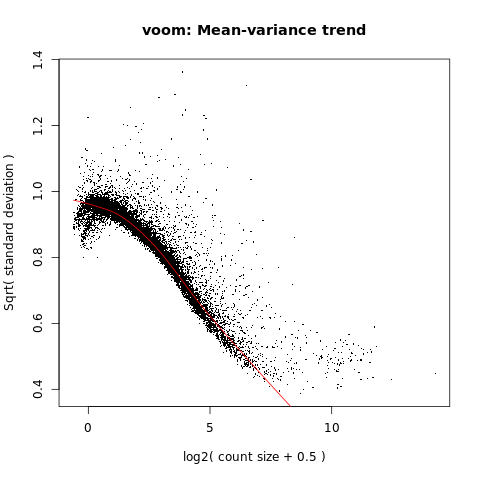

RInterpreterError: Failed to parse and evaluate line 'library(edgeR)\nlibrary(MAST)\nlibrary(zellkonverter)\noptions(max.print=100)\n\nadata_de = readH5AD(\'../../output/de_analysis/adata_de.h5ad\')\n\nfit_model <- function(adata_){\n    d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s, genes=rowData(adata_)$gene, samples=colData(adata_)$sm_name_s)\n    print("Dimensions before subsetting:")\n    print(dim(d))\n    # keep <- filterByExpr(d)\n    # d <- d[keep, , keep.lib.sizes=FALSE]\n    # print("Dimensions after subsetting:")\n    # print(dim(d))\n    d <- calcNormFactors(d)\n    group <- paste0(colData(adata_)$sm_name_s, ".", colData(adata_)$cell_type_s)\n    # group <- colData(adata_)$sm_name_s\n    plate_name <- colData(adata_)$plate_name\n    row <- colData(adata_)$row\n    design <- model.matrix(~ 0 + group + plate_name + row)\n    print("Dimensions of design matrix:")\n    print(dim(design))\n    y <- voom(d, design, plot=TRUE)\n    # y <- estimateDisp(d, design = design)\n    # print(\'normalization finished\')\n    fit <- glmQLFit(y, design)\n    # return(y)\n    return(list("fit"=fit, "design"=design, "y"=y))\n}\nouts <-fit_model(adata_de)\nfit <- outs$fit\ny <- outs$y\ncolnames(y$design)\n'.
R error message: 'Error: Negative counts not allowed'

In [31]:
%%time
%%R 
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)

adata_de = readH5AD('../../output/de_analysis/adata_de.h5ad')

fit_model <- function(adata_){
    d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s, genes=rowData(adata_)$gene, samples=colData(adata_)$sm_name_s)
    print("Dimensions before subsetting:")
    print(dim(d))
    # keep <- filterByExpr(d)
    # d <- d[keep, , keep.lib.sizes=FALSE]
    # print("Dimensions after subsetting:")
    # print(dim(d))
    d <- calcNormFactors(d)
    group <- paste0(colData(adata_)$sm_name_s, ".", colData(adata_)$cell_type_s)
    # group <- colData(adata_)$sm_name_s
    plate_name <- colData(adata_)$plate_name
    row <- colData(adata_)$row
    design <- model.matrix(~ 0 + group + plate_name + row)
    print("Dimensions of design matrix:")
    print(dim(design))
    y <- voom(d, design, plot=TRUE)
    # y <- estimateDisp(d, design = design)
    # print('normalization finished')
    fit <- glmQLFit(y, design)
    # return(y)
    return(list("fit"=fit, "design"=design, "y"=y))
}
outs <-fit_model(adata_de)
fit <- outs$fit
y <- outs$y
colnames(y$design)

In [ ]:
%%time
%%R -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_de)$cell_type)) {
    print(cell_type)
    # create contrast for this cell type
    myContrast <- makeContrasts(paste0("groupstim.", cell_type, "-groupctrl.", cell_type), levels = y$design)
    # perform QLF test
    qlf <- glmQLFTest(fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    # save in the list with the results for all the cell types
    de_per_cell_type[[cell_type]] <- tt$table
}

In [24]:
%%R
plotBCV(y)

Error in plotBCV(outs) : y must be a DGEList.


RInterpreterError: Failed to parse and evaluate line 'plotBCV(outs)\n'.
R error message: 'Error in plotBCV(outs) : y must be a DGEList.'

In [ ]:
%%R -o tt
myContrast <- makeContrasts('groupsm_name_1.celltype_3 - groupsm_name_101.celltype_3', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

The smear plot (also known as MA, M-values vs A-values, plot) shows the log fold-change of the genes as a function of their mean abundance. We generally observe higher logFC at low abundance ranges as read counts are more variable at low abundance resulting in large logFC estimates. If we fit a loess curve to logFC and Average logCPM values, the trend should center around zero. Any deviations from this can indicate that data has not been properly normalised. Genes with large mean expression and large logFC in absolute values can flag biologically interesting genes for investigation and follow-up.

In [ ]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

,logFC,logCPM,F,PValue,FDR
HIST1H1E,1.077114,7.270904,1.583333e+01,0.000100,0.382104
TCEA2,-1.454250,5.154448,1.651094e+01,0.000102,0.382104
SAR1B,-1.096456,5.412958,1.378993e+01,0.000272,0.456486
GEN1,-1.679304,4.820052,1.364341e+01,0.000292,0.456486
PRDM2,0.818659,7.024849,1.344679e+01,0.000322,0.456486
...,...,...,...,...,...
ZNF681,0.000812,4.240840,1.889189e-07,0.999654,1.000000
NFKBIB,0.000245,4.625680,1.411407e-07,0.999701,1.000000
GAK,-0.043404,4.736572,1.073413e-02,0.999816,1.000000
ETFA,0.000058,5.933608,2.140972e-09,0.999963,1.000000


## DE analysis limma

In [ ]:
import limma_utils
from dask import delayed
from dask.distributed import Client, LocalCluster

de_pert_cols = [
    'sm_name',
    'sm_lincs_id',
    'SMILES',
    'dose_uM',
    'timepoint_hr',
    'cell_type',
]
out_dir= '../../output/de_analysis/limma'
os.makedirs(out_dir, exist_ok=True)
def _run_limma_for_cell_type(bulk_adata):
    bulk_adata = bulk_adata.copy()
    compound_name_col = de_pert_cols[0]
    # limma doesn't like dashes etc. in the compound names
    rpert_mapping = bulk_adata.obs[compound_name_col].drop_duplicates() \
        .reset_index(drop=True).reset_index() \
        .set_index(compound_name_col)['index'].to_dict()
    
    bulk_adata.obs['Rpert'] = bulk_adata.obs.apply(
        lambda row: rpert_mapping[row[compound_name_col]], 
        axis='columns',
    ).astype('str')

    compound_name_to_Rpert = bulk_adata.obs.set_index(compound_name_col)['Rpert'].to_dict()
    ref_pert = compound_name_to_Rpert[control_compound]
            
    random_string = binascii.b2a_hex(os.urandom(15)).decode()
    
    limma_utils.limma_fit(
        bulk_adata, 
        design='~0+Rpert+plate_name+row',
        output_path=f'{out_dir}/{random_string}_limma.rds',
        plot_output_path=f'{out_dir}/{random_string}_voom',
        exec_path='limma_fit.r',
    )

    pert_de_dfs = []
    for pert in bulk_adata.obs['Rpert'].unique():
        if pert == ref_pert:
            continue

        pert_de_df = limma_utils.limma_contrast(
            fit_path=f'{out_dir}/{random_string}_limma.rds',
            contrast='Rpert'+pert+'-Rpert'+ref_pert,
            exec_path='limma_contrast.r',
        )

        pert_de_df['Rpert'] = pert

        pert_obs = bulk_adata.obs[bulk_adata.obs['Rpert'].eq(pert)]
        for col in de_pert_cols:
            pert_de_df[col] = pert_obs[col].unique()[0]
        pert_de_dfs.append(pert_de_df)
    de_df = pd.concat(pert_de_dfs, axis=0)
    try:
        os.remove(f'{out_dir}/{random_string}_limma.rds')
        os.remove(f'{out_dir}/{random_string}_voom')
    except FileNotFoundError:
        pass
    return de_df
run_limma_for_cell_type = delayed(_run_limma_for_cell_type)
cluster = LocalCluster(
    n_workers=6,
    processes=True,
    threads_per_worker=1,
    memory_limit='20GB',
)
c = Client(cluster)

In [ ]:
bulk_adata_f = ad.read_h5ad('../../output/de_analysis/bulk_adata_f.h5ad')
bulk_adata_f.var = bulk_adata_f.var.set_index('gene')

cell_types = bulk_adata_f.obs['cell_type'].unique()
de_dfs = []

for cell_type in cell_types:
    cell_type_selection = bulk_adata_f.obs['cell_type'].eq(cell_type)
    cell_type_bulk_adata = bulk_adata_f[cell_type_selection].copy()
    
    de_df = run_limma_for_cell_type(cell_type_bulk_adata)
    
    de_dfs.append(de_df)

de_dfs = c.compute(de_dfs, sync=True)
de_df = pd.concat(de_dfs)

In [ ]:
de_sig_cutoff = 0.05
de_df_copy = de_df.copy()
zero_pval_selection = de_df_copy['P.Value'].eq(0)
de_df_copy.loc[zero_pval_selection, 'P.Value'] = np.finfo(np.float64).eps

de_df_copy['sign_log10_pval'] = np.sign(de_df_copy['logFC']) * -np.log10(de_df_copy['P.Value'])
de_df_copy['is_de'] = de_df_copy['P.Value'].lt(de_sig_cutoff)
de_df_copy['is_de_adj'] = de_df_copy['adj.P.Val'].lt(de_sig_cutoff)

In [ ]:
de_train = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='sign_log10_pval') 
de_train_t = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='t')

In [ ]:
de_train.to_parquet(f'{out_dir}/de_train.parquet')

# EDA on de results

## Missing genes

In [ ]:
de_train = pd.read_parquet(f'../../input/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet')

In [ ]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


## Low cell count 

## Distribution of cell type classification 

## Clusters: de-train vs raw expression

In [ ]:
de_train_a = ad.AnnData(de_train.iloc[:,5:], obs=de_train.iloc[:,:5], var=pd.DataFrame(index=de_train.columns[5:]))
# pca 
sc.pp.pca(de_train_a, n_comps=100)
# umap 
sc.pp.neighbors(de_train_a, n_neighbors=20, n_pcs=100)
sc.tl.umap(de_train_a)

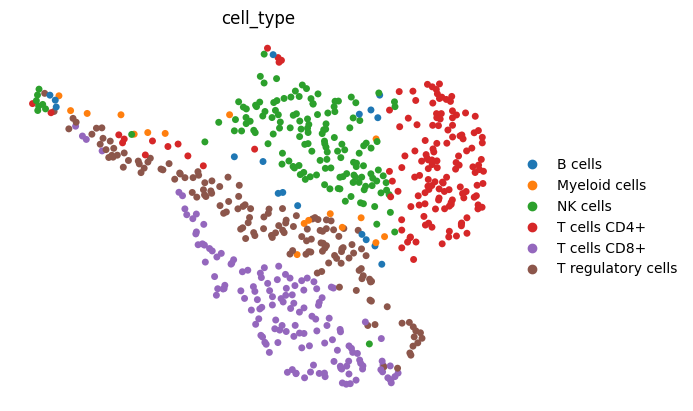

In [ ]:
sc.pl.umap(de_train_a, color=['cell_type'], frameon=False, ncols=2, size=100)

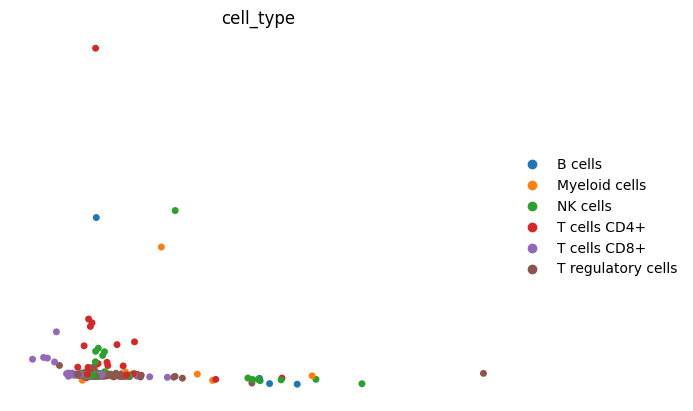

In [ ]:
sc.pl.pca(de_train_a, color=['cell_type'], frameon=False, ncols=2, size=100)

## Top compounds 